## Goals

## Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import textblob
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import robust
from string import punctuation
import gensim
from gensim.models import word2vec

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Neural Network
from sklearn.neural_network import MLPClassifier

import keras
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import os
# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

# 1. Import and Add Basic Features

In [12]:
review = pd.read_csv('boardgame-comments-sample.csv')
review.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
review.head(2)

,reviewer_id,game_id,rating,comment
0,25308,37111,8.5,++++ Thematic +++ Bluff - Many randomness I ...
1,54313,12,8.0,"""well, that ugly artwork certainly helped imme..."


In [13]:
comments = review.comment

In [14]:
# RATINGS ADJUSTMENT: ceiling >= .5 [or] floor < .5
review['rating'] = review.rating.apply(round)

In [15]:
# Check for null values
review.isnull().any()

reviewer_id    False
game_id        False
rating         False
comment        False
dtype: bool

In [16]:
# Functions for finding percentage frequency (capital letters/punctuation)
def per_check(string_value, total):
    percentage = len(string_value)
    if percentage != 0:
        percentage = float(total / percentage) * 100
    else:
        percentage = 0
    return percentage

def punc_count(string_value):
    count = 0
    for c in string_value:
        if c in punctuation:
            count+= 1
    return per_check(string_value, count)

def caplet_count(string_value):
    count = 0
    for c in string_value:
        if c.isupper():
            count+= 1
    return per_check(string_value, count)      

review['c_len'] = review.comment.apply(len)
review['punc_count'] = review.comment.apply(punc_count)
review['caplet_count'] = review.comment.apply(caplet_count)

In [17]:
review.head(2)

,reviewer_id,game_id,rating,comment,c_len,punc_count,caplet_count
0,25308,37111,8,++++ Thematic +++ Bluff - Many randomness I ...,407,4.914005,1.719902
1,54313,12,8,"""well, that ugly artwork certainly helped imme...",100,7.000000,2.000000


### Show Reviewer_ID and Game_ID Counts (Matthew's Suggestion)

In [18]:
userreview = review.groupby('reviewer_id')
# dflist = []
# for r in userreview:
#     dflist.append(r[1])  
review.reviewer_id.value_counts()[0:3]

14263    2
61618    2
52258    2
Name: reviewer_id, dtype: int64

In [19]:
gamereview = review.groupby('game_id')
# dflist = []
# for r in gamereview:
#     dflist.append(r[1])  
review.game_id.value_counts()[0:3]

13       16
822      13
24480     9
Name: game_id, dtype: int64

In [20]:
del review['game_id']
del review['reviewer_id']

# 2. Natural Language Processing Features:

## _Spacy_

In [21]:
nlp = spacy.load('en')

In [29]:
%%time
docs = []
tokens = []
lemma = []
pos = []
deps = []
ents = []
sentences = []

def insert_null(l):
    return [(w if w else '0') for w in l]

pipeline = nlp.pipe(review['comment'].astype('unicode').values,
                    batch_size = 10, 
                    n_threads=4)

CPU times: user 2.12 ms, sys: 568 µs, total: 2.69 ms
Wall time: 2.7 ms


In [30]:
# Create doc
review['doc'] = [doc if doc.is_parsed else None for doc in pipeline]
beep('ping')

Completed: 100 docs out of 847
Completed: 200 docs out of 847
Completed: 300 docs out of 847
Completed: 400 docs out of 847
Completed: 500 docs out of 847
Completed: 600 docs out of 847
Completed: 700 docs out of 847
Completed: 800 docs out of 847
Completed: 847 docs out of 847


In [31]:
# apply features
review['w_len'] = review.doc.apply(len)
review['tokens'] = review.doc.apply(lambda doc: insert_null([tok.text for tok in doc]))
review['lemma'] = review.doc.apply(lambda doc: insert_null([tok.lemma_ for tok in doc]))
review['pos'] = review.doc.apply(lambda doc: insert_null([tok.pos_ for tok in doc]))
review['deps'] = review.doc.apply(lambda doc: insert_null([tok.dep_ for tok in doc]))
review['ents'] = review.doc.apply(lambda doc: insert_null([tok.ent_type_ for tok in doc]))
beep('ping')

In [32]:
review.c_len.max()
print(review.comment[review.c_len == 7977].iloc[0][0:300],end=''); print('...')

[u]The Positive:[/u] (+) The art is not 'great', but it sure is very functional. It supports in understanding the game. Moreover, the components are of good quality (except an unfortunate misprint of some 1$-coins in which some are smaller than others)  (+) The game rules are very structured and lim...


## _TextBlob_

In [33]:
%%time
blobs = review.comment.apply(lambda val: textblob.TextBlob(val))

CPU times: user 7.9 ms, sys: 593 µs, total: 8.5 ms
Wall time: 8.42 ms


In [34]:
review['sent_pol'] = blobs.apply(lambda val: val.sentiment[0])
review['sent_subj'] = blobs.apply(lambda val: val.sentiment[1])

_Pol = Sentiment Polarity (positive or negative word choice)_ <br>
_Subj = Sentiment Subjectivity (objective or subjective word choice)_

In [35]:
# DataFrame With New Spacy and TextBlob Features
review.tail(1)

,rating,comment,c_len,punc_count,caplet_count,doc,w_len,tokens,lemma,pos,deps,ents,sent_pol,sent_subj
846,7,The vanilla version of this game has it's flaw...,144,3.472222,2.083333,"(The, vanilla, version, of, this, game, has, i...",35,"[The, vanilla, version, of, this, game, has, i...","[the, vanilla, version, of, this, game, have, ...","[DET, NOUN, NOUN, ADP, DET, NOUN, VERB, PRON, ...","[det, compound, nsubj, prep, det, pobj, ROOT, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.05,0.45


# 3. Visuals

In [36]:
def MEDIAN_reject_outliers(data, m=3):
    data = data[abs(data - np.median(data)) < m*robust.mad(data)]
    return data[~np.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) <= m*np.std(data)]
    return data[~np.isnan(data)].sort_values()

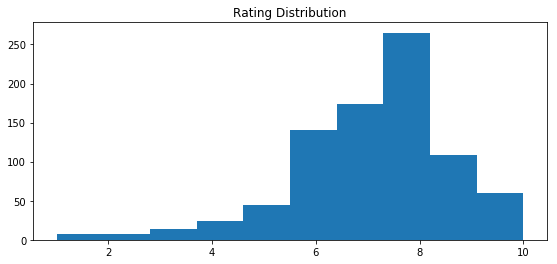

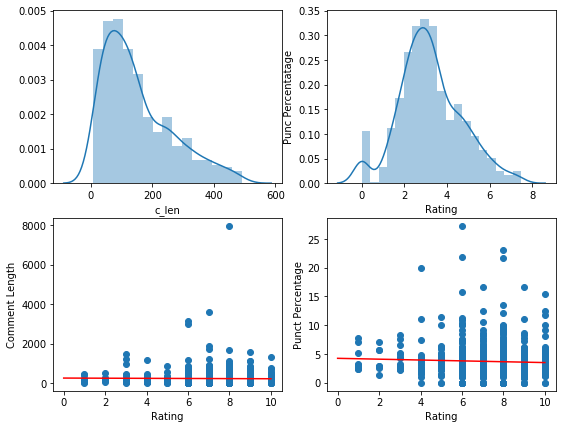

In [37]:
# Ratings
plt.figure(figsize=(9.2,4))
plt.hist(review.rating,bins=10)
plt.title('Rating Distribution')
plt.show()

plt.figure(figsize=(9,7))

plt.subplot(221)
sns.distplot(MEDIAN_reject_outliers(review.c_len))
# plt.title('Average Char Length');

plt.subplot(222)
sns.distplot(MEDIAN_reject_outliers(review.punc_count))
plt.xlabel('Rating');
plt.ylabel('Punc Percentatage');


plt.subplot(223)
plt.scatter(review.rating,review.c_len)
plt.xlabel('Rating')
plt.ylabel('Comment Length')
xlist = []
ylist = []
m,b = np.polyfit(review.rating, review.c_len, 1)
for i in range(0,11):
    ylist.append(i*m + b)
    xlist.append(i)
plt.plot(xlist,ylist,color='r')
# plt.title('Ratings by Review Len')


plt.subplot(224)
plt.scatter(review.rating,review.punc_count);
xlist = []
ylist = []
m,b = np.polyfit(review.rating, review.punc_count, 1)
for i in range(0,11):
    ylist.append(i*m + b)
    xlist.append(i)
plt.plot(xlist,ylist,color='r')
# plt.title('Ratings by Punctuation Percentage');
plt.xlabel('Rating');
plt.ylabel('Punct Percentage');

# 4. Models

In [38]:
features = ['c_len','caplet_count','punc_count','rating','sent_pol','sent_subj']

In [49]:
%%time
y = review['rating']
X = review[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: user 2.79 ms, sys: 614 µs, total: 3.4 ms
Wall time: 2.93 ms


### _Cluster Model_

_Tries to find clusters in the data but doesnt predict anything_ (Not currently relevant)

In [50]:
# Principal Components Analysis PCA (reduces features to 2 for visualization)
pca = PCA(n_components=2)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)

# We know we're looking for three clusters.
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_pca)

#Predicted clusters.
predict=sc.fit_predict(X_train_pca)

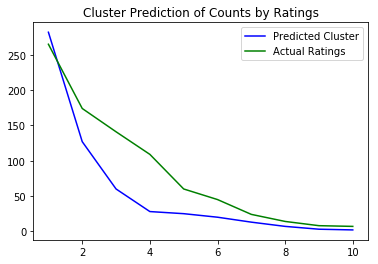

In [51]:
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df.columns = ['comp_1','comp_2']
X_train_pca_df['hue'] = predict

plt.plot([i for i in range(1,11)],list(X_train_pca_df.hue.value_counts()),color ='b');
plt.plot([i for i in range(1,11)],list(review.rating.value_counts()),color ='g');
plt.legend(['Predicted Cluster','Actual Ratings']);
plt.title('Cluster Prediction of Counts by Ratings')
plt.show()

<Figure size 1584x1584 with 0 Axes>

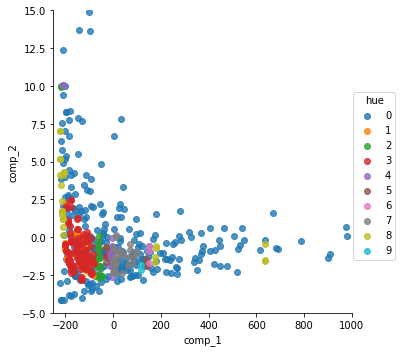

In [52]:
plt.figure(figsize=(22,22));
sns.lmplot(x='comp_1',y='comp_2', hue='hue',data=X_train_pca_df,fit_reg=False)
plt.xlim(-250,1000)
plt.ylim(-5,15)
plt.show()

### _Logistic Regression_

_Operates on probabilities_

In [53]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Check for overfitting:')
print(lr.score(X_train,y_train)*100)
print('')
# Print Model Score Estimation on Same Data
print('Percentage of ratings guessed correctly:')
print(lr.score(X_test,y_test)*100)

Check for overfitting:
35.978835978835974

Percentage of ratings guessed correctly:
34.285714285714285


# 5. Word Embedding - Word2Vec

In [77]:
%%time
review = pd.read_csv('boardgame-comments-english.csv').sample(frac=.1,random_state=42)
review.columns = 'reviewer_id', 'game_id', 'rating', 'comment'

# RATINGS ADJUSTMENT: ceiling >= .5 [or] floor < .5
review['rating'] = review.rating.map(round)

print('Total Comments: {}'.format(review.comment.count()))

Total Comments: 84164
CPU times: user 2.63 s, sys: 356 ms, total: 2.99 s
Wall time: 2.93 s


In [78]:
%%time
tokenize = lambda val: [b.lower() for b in textblob.TextBlob(val).words]
sentences_blob = review.comment.map(tokenize)
review['token'] = sentences_blob
beep('ping')

CPU times: user 50.5 s, sys: 763 ms, total: 51.3 s
Wall time: 54.1 s


In [79]:
%%time
load_model = False

if load_model:
    # # load model
    word_vec = word2vec.Word2Vec.load('full_word2vec_blob.bin')
    vec_size = word_vec.layer1_size
else: 
    vec_size = 50
    word_vec = word2vec.Word2Vec(
        sentences_blob,
        workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
        min_count=5,  # Minimum word count threshold.
        window=6,      # Number of words around target word to consider.
        sg=0,          # Use CBOW because our corpus is small.
        sample=1e-3 ,  # Penalize frequent words.
        size=vec_size,      # Word vector length.
        hs=1           # Use hierarchical softmax.
    )
    
    # save model
    word_vec.save('full_word2vec_blob.bin')

# List of words in model.
vocab = word_vec.wv.vocab.keys()
beep('ping')

CPU times: user 54.4 s, sys: 413 ms, total: 54.8 s
Wall time: 19.6 s


In [80]:
%%time
vec_new = np.array([.5 for i in range(0,vec_size)])
review['vectors'] = review.token.apply(lambda val: [word_vec[w] if w in vocab else vec_new for w in val])
beep('ping')

CPU times: user 15.8 s, sys: 394 ms, total: 16.2 s
Wall time: 18.3 s


### TBD

In [81]:
w1,w2,w3 = 'gamer','player','game'
print(word_vec.most_similar(positive=[w1, w2], negative=[w3], topn=1))

w1 = 'board'
print(word_vec.wv.most_similar(positive=w1,topn=3))

w1 = 'hard'
print(word_vec.wv.most_similar(positive=w1,topn=3))

[('persons', 0.6186925768852234)]
[('map', 0.7458446621894836), ('website', 0.6388208866119385), ('internet', 0.62421715259552)]
[('difficult', 0.9154154062271118), ('easy', 0.8294994831085205), ('tough', 0.6766805052757263)]


# 6. Comprehensive Neural Network

_Slow Method_

_Fast Method_

In [75]:
%%time

pad, max_words = [0 for i in range(0,vec_size)], 100
def manual_pad(val):
    empty = max_words-len(val)
    for i in range(0,empty):
        val.append(pad)
    
    return [i for i in val[0:max_words+1]]


review.vectors=review.vectors.map(manual_pad)

CPU times: user 45.5 ms, sys: 4.04 ms, total: 49.6 ms
Wall time: 27.2 ms


In [76]:
review.vectors

0      [[0.1740753, -0.039500095, 0.07298879, 0.24338...
1      [[0.32842964, -0.075483866, 0.11435159, 0.4406...
2      [[0.19339791, -0.07377809, 0.04802373, 0.20871...
3      [[0.265319, -0.048252538, 0.1196339, 0.3886518...
4      [[0.3279921, -0.10454835, 0.10703331, 0.409412...
5      [[0.34569082, -0.09870648, 0.10256475, 0.44392...
6      [[0.41111916, -0.121255964, 0.17135201, 0.5303...
7      [[0.32995507, -0.06354366, 0.13083938, 0.40524...
8      [[0.41111916, -0.121255964, 0.17135201, 0.5303...
9      [[0.20311399, -0.0492009, 0.081262074, 0.24157...
10     [[0.31899443, -0.06469505, 0.13190363, 0.48418...
11     [[0.31899443, -0.06469505, 0.13190363, 0.48418...
12     [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,...
13     [[0.20972817, -0.042973485, 0.084055, 0.263332...
14     [[0.36832264, -0.085874766, 0.16449495, 0.5438...
15     [[0.41111916, -0.121255964, 0.17135201, 0.5303...
16     [[0.34569082, -0.09870648, 0.10256475, 0.44392...
17     [[0.30709165, -0.0880293

In [118]:
%%time
y = review['rating'].astype(int).ravel()
X = pd.DataFrame([list(i[0]) for i in review.vectors])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: user 13.7 ms, sys: 1.36 ms, total: 15.1 ms
Wall time: 14 ms


#### _A - Logistic Regression w/ Vectors_

In [110]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
print('Check for overfitting:')
print(lr.score(X_train,y_train)*100)
print('')
# Print Model Score Estimation on Same Data
print('Percentage of ratings guessed correctly:')
print(lr.score(X_test,y_test)*100)

Check for overfitting:
31.569664902998234

Percentage of ratings guessed correctly:
30.714285714285715


#### _B - MLP Neural NN w/ Vectors_

In [112]:
mlp = MLPClassifier()
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [113]:
mlp.score(X_test,y_test)

0.30714285714285716

#### _C - Keras Sequential NN_

In [140]:
y_test = y_test.ravel()
y_train = y_train.ravel()

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [141]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(vec_size,)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(11, activation='softmax'))

In [142]:
batch_size = 5
epochs = 10

In [143]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [144]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

beep()

Train on 567 samples, validate on 280 samples
Epoch 1/10
567/567 [==============================] - 1s 3ms/step - loss: 1.9876 - acc: 0.2734 - val_loss: 1.9230 - val_acc: 0.2071
Epoch 2/10
567/567 [==============================] - 1s 2ms/step - loss: 1.9437 - acc: 0.2892 - val_loss: 1.8706 - val_acc: 0.3071
Epoch 3/10
567/567 [==============================] - 1s 2ms/step - loss: 1.9007 - acc: 0.3016 - val_loss: 1.8618 - val_acc: 0.3071
Epoch 4/10
567/567 [==============================] - 1s 2ms/step - loss: 1.8936 - acc: 0.3157 - val_loss: 1.8804 - val_acc: 0.2179
Epoch 5/10
567/567 [==============================] - 1s 2ms/step - loss: 1.8936 - acc: 0.3122 - val_loss: 1.8529 - val_acc: 0.3071
Epoch 6/10
567/567 [==============================] - 1s 2ms/step - loss: 1.8877 - acc: 0.3157 - val_loss: 1.8429 - val_acc: 0.3071
Epoch 7/10
567/567 [==============================] - 1s 2ms/step - loss: 1.8944 - acc: 0.3139 - val_loss: 1.8463 - val_acc: 0.3071
Epoch 8/10
567/567 [==========

In [145]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.842319083213806
Test accuracy: 0.30714285671710967


## Word Similarity Visualization

In [ ]:
X = word_vec[word_vec.wv.vocab]
graph_tsne = TSNE(n_components=2)
result = graph_tsne.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result[:, 0], result[:, 1])
words = list(word_vec.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# plt.ylim(-0.006,0.008)
# plt.xlim(-.02,.04)
plt.show()

graph_pca = PCA(n_components=2)
result = graph_pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result[:, 0], result[:, 1])
words = list(word_vec.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# plt.ylim(-0.006,0.008)
# plt.xlim(-.02,.04)
plt.show()
beep()